# Q3. How best to predict the topic of a new review?

## Table of Contents:

* [Topic Classification](#chapter5_)
    * [TF–IDF Vectors](#chapter5_1)
    * [Predictive Models](#chapter5_2)
        * [Random Forest Classifier](#chapter5_2_1)
        * [Naive Bayes Classifier](#chapter5_2_2)
        * [Support Vector Machines](#chapter5_2_3)

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")


import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en.examples import sentences

import pickle 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



[Back to TOC](#Table-of-Contents:)

<a class="anchor" id='chapter5_'></a>

# Topic Classification

Packages required: <br>
- spacy https://spacy.io/usage
- nltk.tokenize https://www.nltk.org/api/nltk.tokenize.html
- sklearn https://pypi.org/project/scikit-learn/

<a class="anchor" id='chapter5_1'></a>
## TF–IDF Vectors

**TF-IDF** is a **score** that represents the **relative importance of a word in the review and the entire corpus**. TF stands for Term Frequency, and IDF stands for Inverse Document Frequency.<br>

$TF\_IDF(w,t) = TF(w,t) x log(\frac{N}{DF(w)})$

where: <br>
w: word <br>
t: text <br>
N: number of texts in the corpus



In [2]:
# Upload sample of reviews with relative topic
df_reviews_sample_topics = pd.read_pickle('./data/df_reviews_sample_topics.pkl')

In [3]:
df_reviews_sample_topics.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length_comments,language,comments_english,polarity_compound,sentiment,main_topic,secondary_topic
39978,735370,151499476,2017-05-13,107924476,Jutta,eine schön gelegene wohnung in der etage die w...,59,de,a beautifully located apartment on the same fl...,0.0258,neu,5,6
196555,5909451,142261214,2017-04-07,118986470,Michael,alles bestens sehr gute lage nahe der piazza d...,25,de,"everything was very good, very good location n...",0.8803,pos,1,3
340512,14976201,437134397,2019-04-14,129853528,Kristine,das airbnb hat uns sehr gut gefallen wir haben...,120,de,"We liked the airbnb very much, although we onl...",0.9154,pos,6,3
189256,5745043,658966293,2020-08-31,160489786,Mark,perfekt für einen urlaub in florenz und der an...,15,de,perfect for a vacation in florence and traveli...,0.5719,pos,3,7
149460,4143454,179633637,2017-08-08,97926976,Uwe,wir hatten als familie pesonen eine sehr schö...,96,de,we had a very nice time as a family pesonen in...,0.9432,pos,7,3


In [4]:
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])

In [5]:
def pre_process_text(text):
    
    '''Clean and pre-process data.
    '''
    
    cleaned_text = []
    document = nlp.pipe(text, batch_size=256, n_process=6)
    for doc in document:
        text = [
            token.lemma_
            for token in doc
            if not token.is_punct
            and not token.is_stop
            and not token.like_num
            and token.is_alpha
            and len(token.orth_) > 2
        ]
        cleaned_text.append(" ".join(text).lower())
    return cleaned_text

In [6]:
def sentence_to_words(cleaned_text):
    
    '''Tokenize data
    '''
    
    data_words = []
    for sentence in cleaned_text:
        item = word_tokenize(sentence)
        data_words.append(item)
    return data_words

In [7]:
# List column 'comments_english' from dataframe
comments_list = df_reviews_sample_topics['comments_english'].to_list()

# Clean and pre-process comments:
# Remove punctuation, stopwords, numbers, word having length < 2, tokenize, lemmatize
comments_parsed = pre_process_text(comments_list)

# Save as a new column
df_reviews_sample_topics['comments_en_parsed'] = comments_parsed

In [8]:
df_reviews_sample_topics.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length_comments,language,comments_english,polarity_compound,sentiment,main_topic,secondary_topic,comments_en_parsed
39978,735370,151499476,2017-05-13,107924476,Jutta,eine schön gelegene wohnung in der etage die w...,59,de,a beautifully located apartment on the same fl...,0.0258,neu,5,6,beautifully locate apartment floor apartment u...
196555,5909451,142261214,2017-04-07,118986470,Michael,alles bestens sehr gute lage nahe der piazza d...,25,de,"everything was very good, very good location n...",0.8803,pos,1,3,good good location near piazza della signoriab...
340512,14976201,437134397,2019-04-14,129853528,Kristine,das airbnb hat uns sehr gut gefallen wir haben...,120,de,"We liked the airbnb very much, although we onl...",0.9154,pos,6,3,like airbnb spend day endure long clean beauti...
189256,5745043,658966293,2020-08-31,160489786,Mark,perfekt für einen urlaub in florenz und der an...,15,de,perfect for a vacation in florence and traveli...,0.5719,pos,3,7,perfect vacation florence travel car rental car
149460,4143454,179633637,2017-08-08,97926976,Uwe,wir hatten als familie pesonen eine sehr schö...,96,de,we had a very nice time as a family pesonen in...,0.9432,pos,7,3,nice time family pesonen apartment ideal disco...


In [9]:
df_reviews_sample_topics.shape

(51047, 14)

In [10]:
# Train-test split to test the models

X = df_reviews_sample_topics['comments_en_parsed']
y = df_reviews_sample_topics['main_topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Tfidfvectorizer

# Parameters selection
min_df = 10
max_df = 1.
max_features = 300

tfidf = TfidfVectorizer(stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True,
                        )
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(40837, 300)
(10210, 300)


In [12]:
# Create a dictionary with topics

topic_list = {0: 'Good feelings', 
              1: 'Location', 
              2: 'Tips', 
              3: 'Accommodation benefits', 
              4: 'Host communication', 
              5: 'Accommodation features', 
              6: 'Complaints', 
              7: 'Good experience'
             }

[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter5_2'></a>
## Predictive Models

<a class="anchor" id='chapter5_2_1'></a>
### Random Forest Classifier

In [14]:
#Randomized Search Cross Validation

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

#print(random_grid)

In [15]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [16]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.5573866363429649


In [17]:
best_rfc = random_search.best_estimator_

In [18]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(max_features='sqrt', min_samples_split=5,
                       n_estimators=600, random_state=8)

In [19]:
rfc_pred = best_rfc.predict(features_test)

In [20]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train))*100)

The training accuracy is: 
98.8637754977104


In [21]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred)*100)

The test accuracy is: 
56.71890303623898


In [22]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      1348
           1       0.54      0.69      0.60      1599
           2       0.56      0.41      0.48       952
           3       0.60      0.60      0.60      1422
           4       0.58      0.53      0.55      1399
           5       0.57      0.55      0.56      1166
           6       0.56      0.42      0.48       760
           7       0.55      0.54      0.54      1564

    accuracy                           0.57     10210
   macro avg       0.57      0.55      0.56     10210
weighted avg       0.57      0.57      0.56     10210



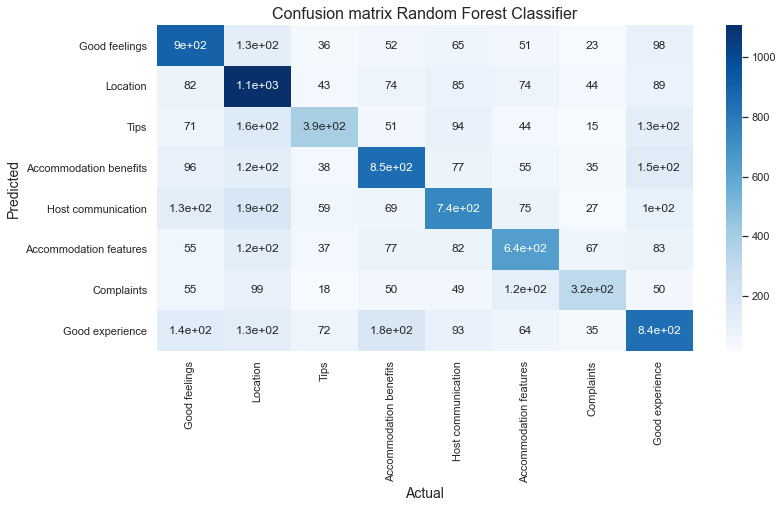

In [23]:
# Confusion Matrix

conf_matrix_RFC = confusion_matrix(labels_test, rfc_pred)

plt.figure(figsize=(12,6))

sns.heatmap(conf_matrix_RFC, 
            annot=True,
            xticklabels=topic_list.values(), 
            yticklabels=topic_list.values(),
            cmap="Blues")
plt.ylabel('Predicted', fontsize=14)
plt.xlabel('Actual', fontsize=14)
plt.title('Confusion matrix Random Forest Classifier', fontsize=16)
plt.show()

[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter5_2_2'></a>
### Naive Bayes Classifier

In [24]:
# Fit the training dataset on the NB classifier multinomial variant

NaiveBayesClassifier = naive_bayes.MultinomialNB()

NaiveBayesClassifier.fit(features_train,labels_train)

# predict the labels on test set
NB_pred = NaiveBayesClassifier.predict(features_test)

In [25]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, NaiveBayesClassifier.predict(features_train))*100)

The training accuracy is: 
63.93956461052477


In [26]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, NB_pred)*100)

The test accuracy is: 
62.69343780607248


In [27]:
# Classification report
print("Classification report")
print(classification_report(labels_test,NB_pred))

Classification report
              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1348
           1       0.59      0.77      0.67      1599
           2       0.78      0.40      0.53       952
           3       0.68      0.66      0.67      1422
           4       0.68      0.60      0.63      1399
           5       0.63      0.61      0.62      1166
           6       0.80      0.39      0.52       760
           7       0.54      0.68      0.60      1564

    accuracy                           0.63     10210
   macro avg       0.66      0.60      0.61     10210
weighted avg       0.65      0.63      0.62     10210



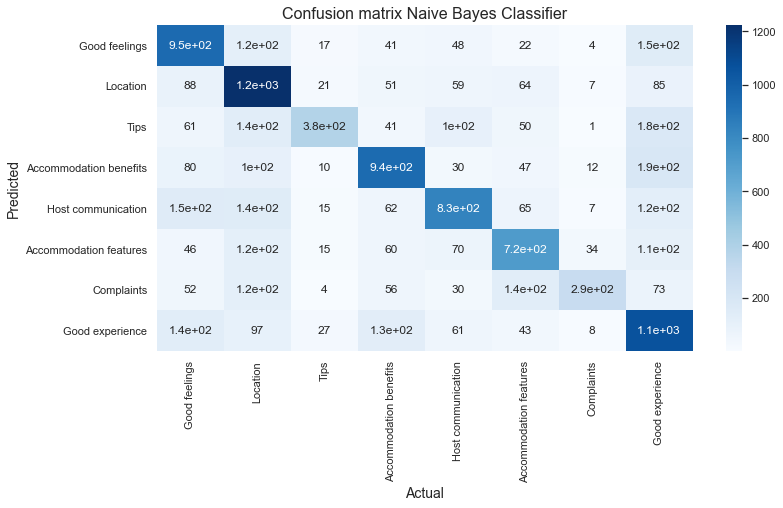

In [28]:
# Confusion Matrix

conf_matrix_NB = confusion_matrix(labels_test, NB_pred)

plt.figure(figsize=(12,6))

sns.heatmap(conf_matrix_NB, 
            annot=True,
            xticklabels=topic_list.values(), 
            yticklabels=topic_list.values(),
            cmap="Blues")
plt.ylabel('Predicted', fontsize=14)
plt.xlabel('Actual', fontsize=14)
plt.title('Confusion matrix Naive Bayes Classifier', fontsize=16)
plt.show()

[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter5_2_3'></a>
### Support Vector Machines

In [29]:
# Fit the training dataset on the Linear SVM classifier
SVM_linear = LinearSVC()

SVM_linear.fit(features_train,labels_train)

# predict the labels on test set
SVM_pred = SVM_linear.predict(features_test)

In [30]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, SVM_linear.predict(features_train))*100)

The training accuracy is: 
67.9555305237897


In [31]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, SVM_pred)*100)

The test accuracy is: 
66.1998041136141


In [32]:
# Classification report
print("Classification report")
print(classification_report(labels_test, SVM_pred))

Classification report
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      1348
           1       0.68      0.72      0.70      1599
           2       0.66      0.55      0.60       952
           3       0.70      0.70      0.70      1422
           4       0.67      0.64      0.66      1399
           5       0.67      0.61      0.64      1166
           6       0.66      0.59      0.62       760
           7       0.62      0.63      0.62      1564

    accuracy                           0.66     10210
   macro avg       0.66      0.65      0.66     10210
weighted avg       0.66      0.66      0.66     10210



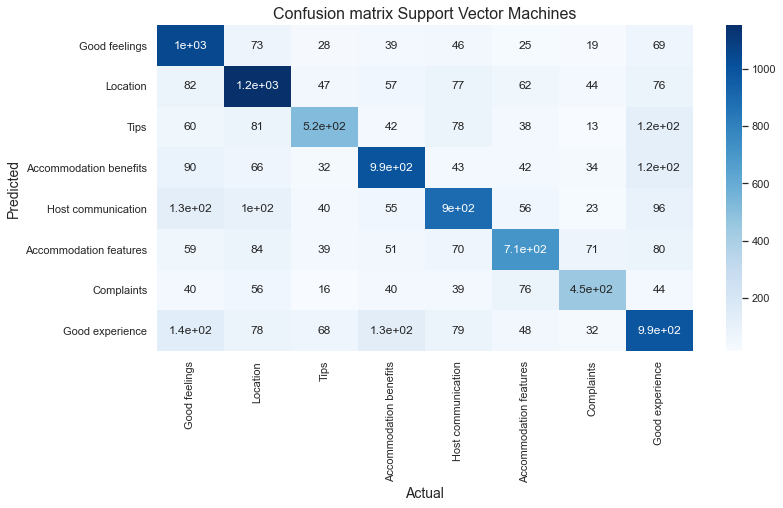

In [33]:
# Confusion Matrix

conf_matrix_SVM = confusion_matrix(labels_test, SVM_pred)

plt.figure(figsize=(12,6))

sns.heatmap(conf_matrix_SVM, 
            annot=True,
            xticklabels=topic_list.values(), 
            yticklabels=topic_list.values(),
            cmap="Blues")
plt.ylabel('Predicted', fontsize=14)
plt.xlabel('Actual', fontsize=14)
plt.title('Confusion matrix Support Vector Machines', fontsize=16)
plt.show()

[Back to TOC](#Table-of-Contents:)